**Sumit Parwal**                              

**HW-3**                                       

**USC-ID ->5174593050**

In [75]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import os
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.preprocessing import normalize
from sklearn.feature_selection import RFECV
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import seaborn as sns

In [63]:
# init
folder_namedict = 'AReM/'

In [ ]:
filetype = '.csv'


In [ ]:
classes = ['walking', 'standing', 'sitting', 'lying', 'cycling', 'bending1', 'bending2']
file_name_prefix = 'dataset'

Minimum, maximum, mean, median, standard deviation, first quartile, and third quartile are usually used in time series classification. 


(c) ii

In [64]:
def load_data(num_parts):
    train_dataset = list()
    test_dataset = list()
    for label in range(len(classes)):    
        class_path = folder_namedict + classes[label] + '/'
        path, dirs, files = next(os.walk(class_path))
        file_count = len(files)
#         trace(file_count)
        classData_train = list()
        classData_test = list()
        for fileIndex in range(1, file_count+1):
            csvname = class_path + file_name_prefix + str(fileIndex) + filetype
    #         print('processing ', csvname)
#             print(csvname)
            df = pd.read_csv(csvname, skiprows=range(0, 4))
            num_singlepart = int(df.shape[0]/num_parts)
            for i in range(0, num_parts):
                df_p = df[:num_singlepart]
                df = df.drop(df.index[:num_singlepart])
                stat_pd = df_p.describe().drop('count').drop(columns='# Columns: time').transpose()
                newInstance = pd.concat([stat_pd.loc['avg_rss12'], 
                                         stat_pd.loc['var_rss12'], 
                                         stat_pd.loc['avg_rss13'], 
                                         stat_pd.loc['var_rss13'], 
                                         stat_pd.loc['avg_rss23'], 
                                         stat_pd.loc['var_rss23']], 
                                         axis=0, sort=False)

                newInstance = newInstance.to_frame().transpose()
                newInstance.columns = ['mean1', 'std1', 'min1', '25%_1', 
                                       '50%_1', '75%_1', 'max1', 'mean2', 'std2', 'min2', '25%_2', 
                                       '50%_2', '75%_2', 'max2', 'mean3', 'std3', 'min3', '25%_3', 
                                       '50%_3', '75%_3', 'max3', 'mean4', 'std4', 'min4', '25%_4', 
                                       '50%_4', '75%_4', 'max4', 'mean5', 'std5', 'min5', '25%_5', 
                                       '50%_5', '75%_5', 'max5', 'mean6', 'std6', 'min6', '25%_6', 
                                       '50%_6', '75%_6', 'max6'] 
            #     print(newInstance)
#                 classData.append(newInstance)
                if classes[label] == 'bending1' or classes[label] == 'bending2':
                    if fileIndex == 1 or fileIndex == 2:
                        classData_test.append(newInstance)
                    else:
                        classData_train.append(newInstance)
                else:
                    if fileIndex == 1 or fileIndex == 2 or fileIndex == 3:
                        classData_test.append(newInstance)
                    else:
                        classData_train.append(newInstance)
#         print(classData_test)               
        classData_test = pd.concat(classData_test, ignore_index=True)
        classData_train = pd.concat(classData_train, ignore_index=True)
         
        classData_train['label'] = classes[label]
        classData_test['label'] = classes[label]
        if classes[label]=='bending1' or classes[label]=='bending2':
            classData_train['label_b'] = 1
            classData_test['label_b'] = 1    
        else:
            classData_train['label_b'] = 0
            classData_test['label_b'] = 0              
#         dataset.append(classData) 
#         print(classData_train) 
        train_dataset.append(classData_train)
        test_dataset.append(classData_test)
    train_dataset = pd.concat(train_dataset, ignore_index=True, sort=False)
    test_dataset = pd.concat(test_dataset, ignore_index=True, sort=False)
    return train_dataset, test_dataset

In [70]:
train_dataset, test_dataset = load_data(1)
total_dataset = pd.concat([train_dataset,  test_dataset])
print(total_dataset.head())
total_dataset.shape


       mean1      std1   min1  25%_1   50%_1    75%_1   max1     mean2  \
0  35.193333  4.751868  18.00  32.00  36.000  38.7500  46.00  4.321021   
1  34.763333  4.742208  20.75  31.67  35.290  38.2500  46.25  4.223792   
2  34.935812  4.645944  21.50  32.00  35.500  38.0625  51.00  4.115750   
3  34.333042  4.948770  18.33  31.25  34.750  38.0000  47.67  4.396958   
4  34.599875  4.731790  18.33  31.50  35.125  38.0000  45.75  4.398833   

       std2  min2  ...   max5     mean6      std6  min6  25%_6  50%_6  75%_6  \
0  2.625516   0.0  ...  23.50  3.241958  1.769182   0.0  1.885  3.015  4.440   
1  2.278004   0.0  ...  25.50  3.288271  1.647528   0.0  2.050  3.270  4.305   
2  2.335243   0.0  ...  25.00  3.280021  1.700918   0.0  2.120  3.015  4.500   
3  2.568680   0.0  ...  24.00  3.261583  1.617290   0.0  2.050  2.980  4.320   
4  2.538521   0.0  ...  23.25  3.289542  1.680170   0.0  2.120  3.015  4.260   

    max6    label  label_b  
0   8.50  walking        0  
1   9.39  walkin

(88, 44)

c)iiiI

In [71]:
for column in train_dataset.columns.values:
    series = train_dataset[column]
    
    print('\n',column)
    
    print('Std ::', series.describe()['std'])
    print('Bootstrap CI ::', bs.bootstrap(np.asarray(series), stat_func=bs_stats.std, alpha=0.1,num_iterations=10000))


 mean1
Std :: 4.917716534053915
Bootstrap CI :: 4.88195084823011    (4.380866496945465, 5.474730177605165)

 std1
Std :: 1.7586291583940323
Bootstrap CI :: 1.7458389584050438    (1.562716399968777, 1.960816541208731)

 min1
Std :: 8.794294864591922
Bootstrap CI :: 8.730335507644275    (7.4854852867466075, 9.999035256770012)

 25%_1
Std :: 5.731262069418449
Bootstrap CI :: 5.68957961026708    (5.230701935803017, 6.26850414014409)

 50%_1
Std :: 4.956110901988048
Bootstrap CI :: 4.920065980691553    (4.39228987968188, 5.5493479976425935)

 75%_1
Std :: 4.7836451331946375
Bootstrap CI :: 4.748854525045172    (4.0117576662220875, 5.612168553524157)

 max1
Std :: 4.429181529313045
Bootstrap CI :: 4.396968872496197    (3.4378468652375025, 5.54521180685683)

 mean2
Std :: 1.6006605313356368
Bootstrap CI :: 1.5890192093363136    (1.4519630868696491, 1.7833465574736502)

 std2
Std :: 0.9027694356426305
Bootstrap CI :: 0.8962037526100803    (0.8359495143074174, 0.9883244033361551)

 min2
Std ::

KeyError: 'std'

(c) iv: The three most important time-domain features I selected are min, mean, and max. 

**(d) i**

In [85]:
#here we have two select 1,2,6 to plot scatter plots So:
def select_data(train, test):    
    selected_features = ['min1', 'max1', 'mean1', 'min2', 
                         'max2', 'mean2', 'min6', 'max6', 'mean6', 'label_b']
    train_selected = train[selected_features]
    test_selected = test[selected_features]
    return train_selected, test_selected
train_selected, test_selected = select_data(train_dataset, train_dataset)

In [86]:
train_selected.head()

,min1,max1,mean1,min2,max2,mean2,min6,max6,mean6,label_b
0,18.00,46.00,35.193333,0.0,16.20,4.321021,0.0,8.50,3.241958,0
1,20.75,46.25,34.763333,0.0,12.68,4.223792,0.0,9.39,3.288271,0
2,21.50,51.00,34.935812,0.0,12.21,4.115750,0.0,10.21,3.280021,0
3,18.33,47.67,34.333042,0.0,12.48,4.396958,0.0,8.01,3.261583,0
4,18.33,45.75,34.599875,0.0,15.37,4.398833,0.0,8.86,3.289542,0


### (d) i

**Class 0:Others(blue)
Class 1:Bending(orange)**

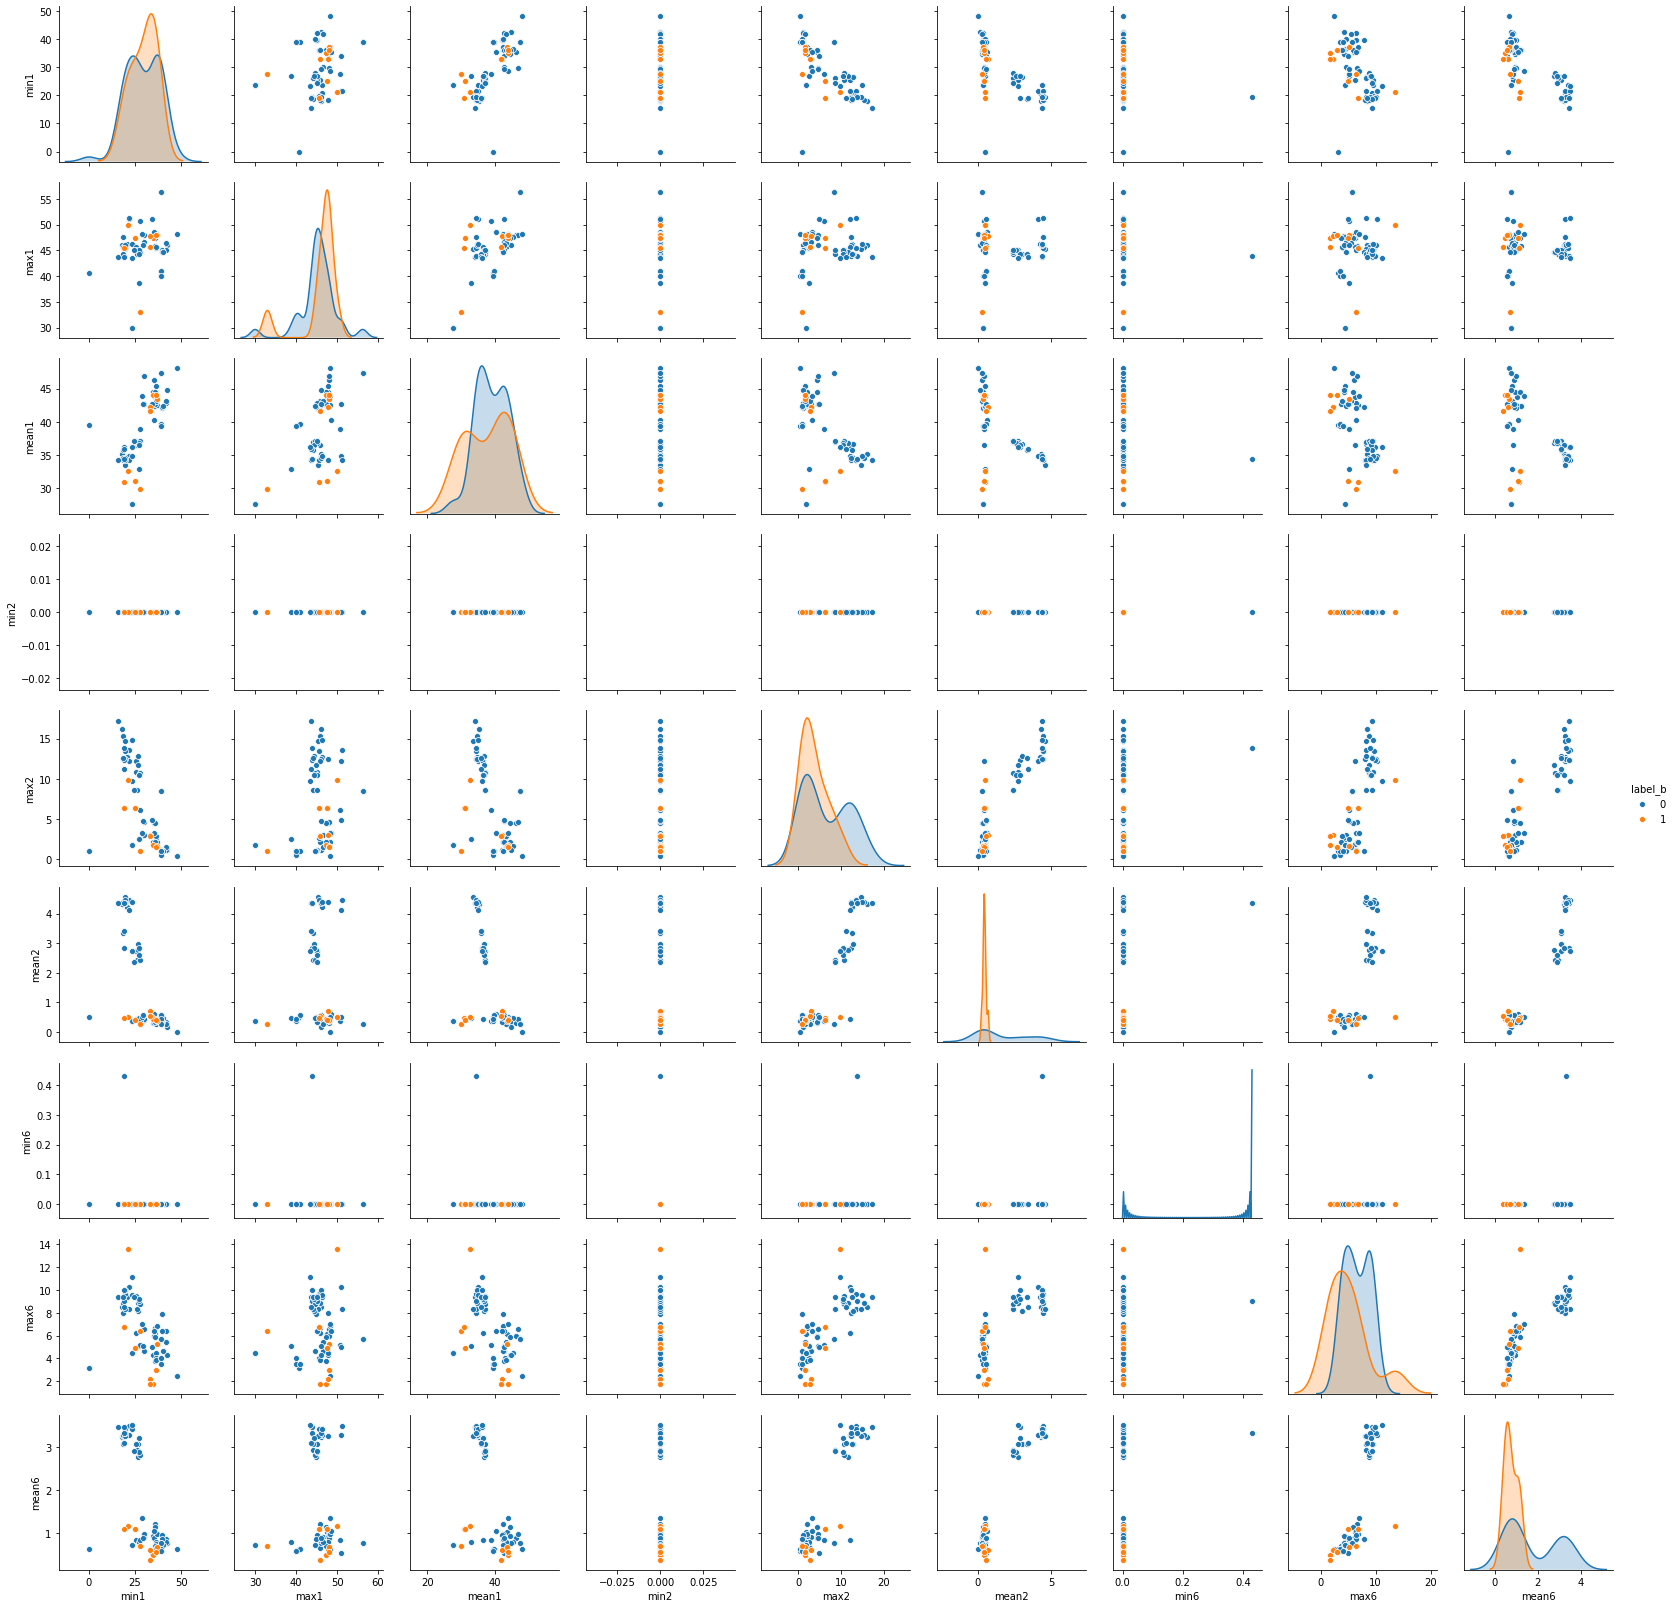

In [87]:
import warnings
warnings.filterwarnings('ignore')
def plotScatter(df):
    return sns.pairplot(df, hue="label_b",vars=df.iloc[:,:9])
plotScatter(train_selected)

## (d) ii
Break dataset into two


**Observation**: After break time series into two, the scatters of different classes look more seperatable

In [88]:
train_dataset_2, test_dataset_2 = load_data(2)
train_selected_break12, test_selected_break12 = select_data(train_dataset_2, test_dataset_2)
test_selected_break12= test_selected_break12.rename(columns={'min6': 'min12', 'max6': 'max12', 'mean6': 'mean12'})


In [89]:
test_selected_break12.head()

,min1,max1,mean1,min2,max2,mean2,min12,max12,mean12,label_b
0,22.33,42.50,34.334833,0.00,12.19,3.974958,0.0,9.74,3.387500,0
1,19.33,43.50,34.120708,0.00,14.50,4.016500,0.0,8.86,3.400750,0
2,18.67,45.00,33.762958,0.43,13.05,4.400833,0.0,8.46,3.378708,0
3,12.50,43.25,33.256500,0.00,12.85,4.500708,0.0,8.96,3.378250,0
4,15.00,45.33,33.591625,0.00,12.53,4.573042,0.0,8.99,3.281958,0


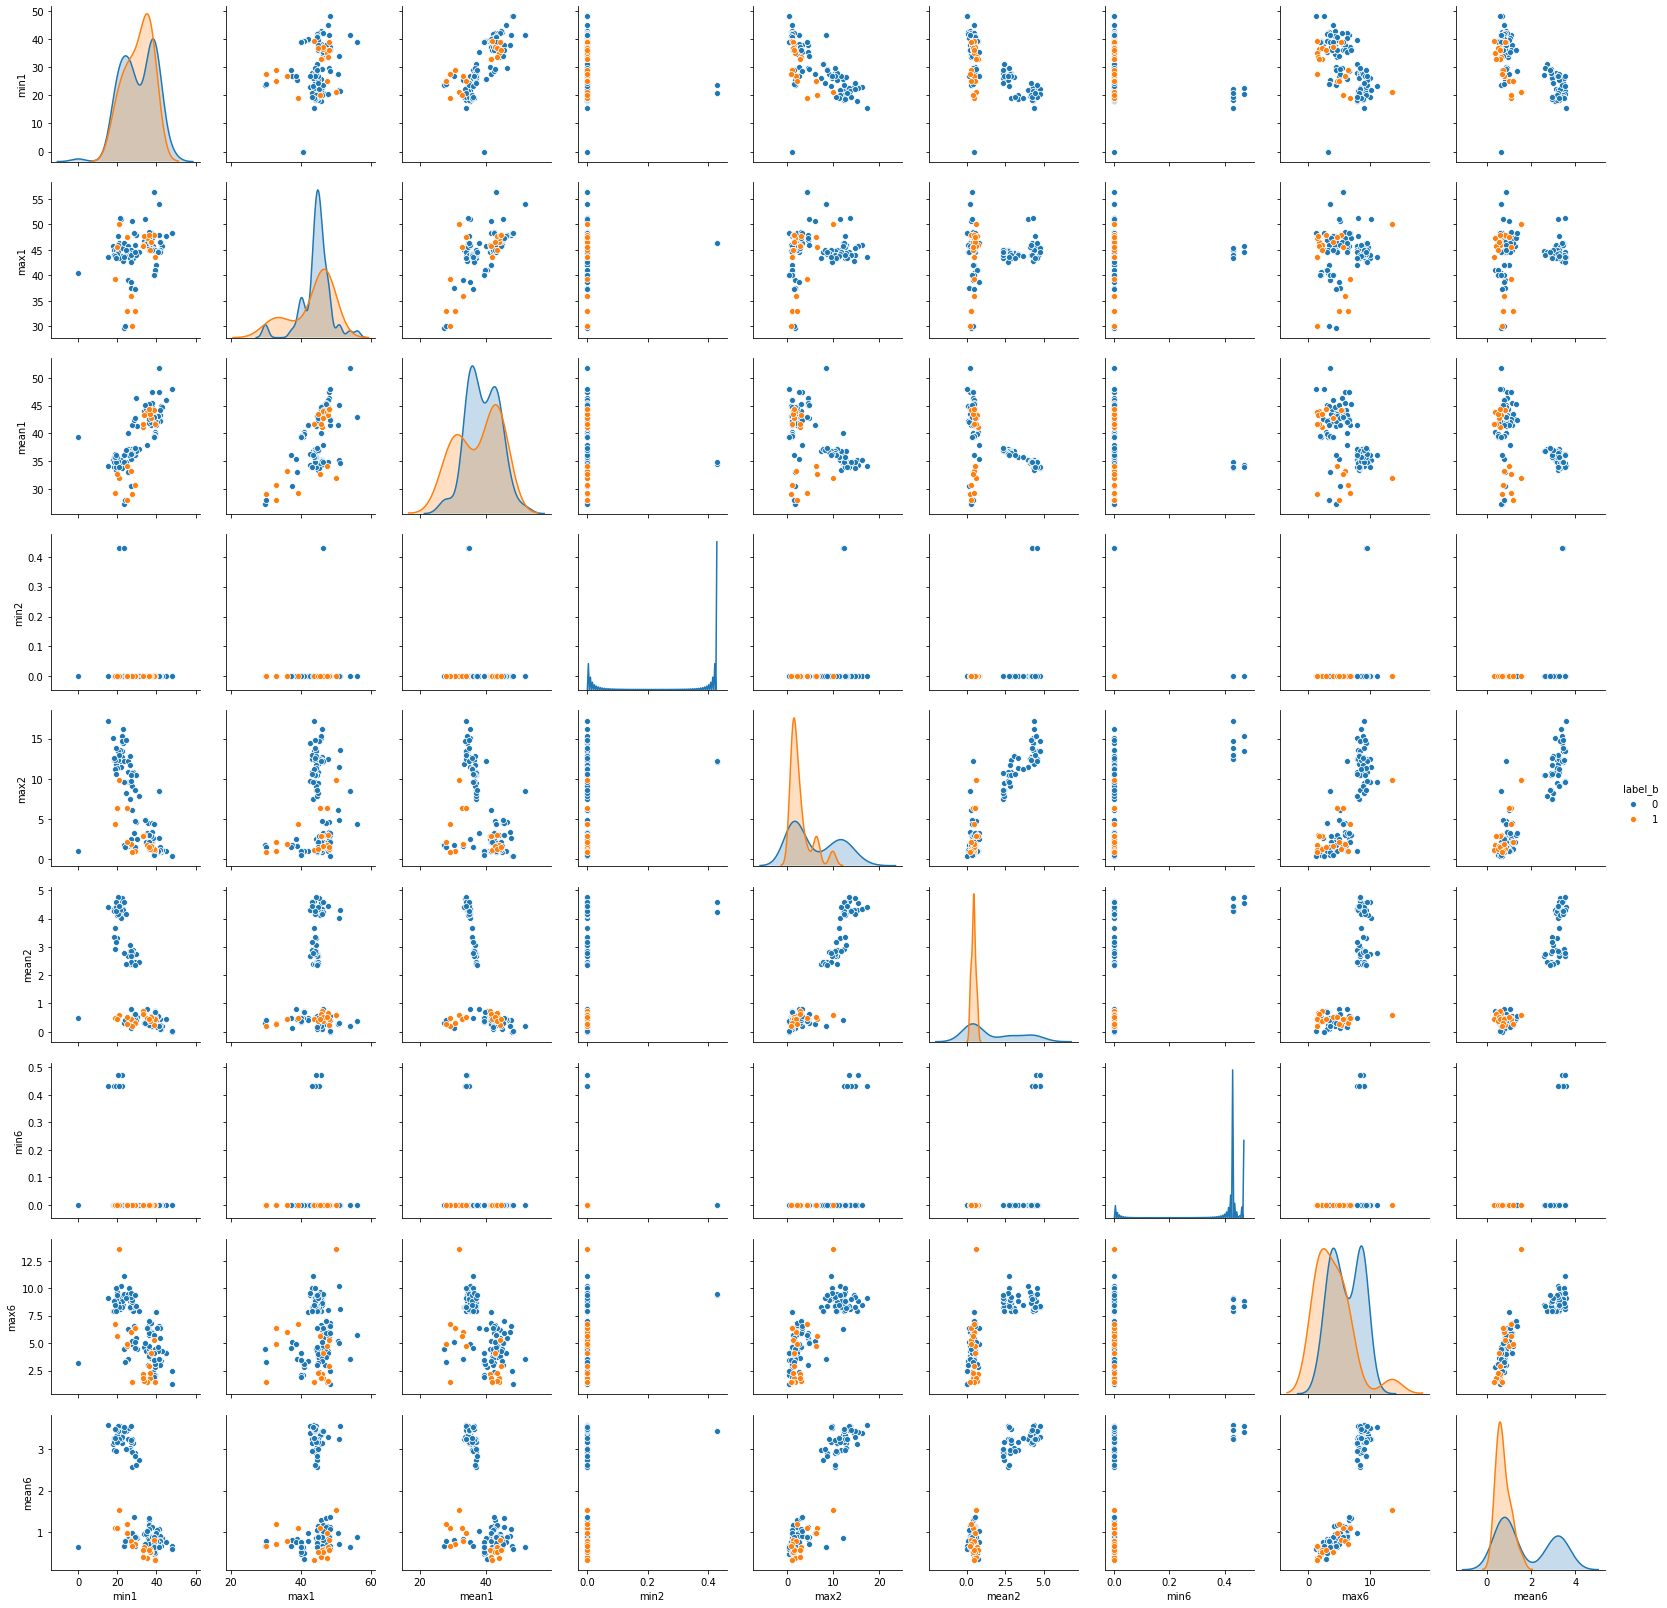

In [94]:
sns.pairplot(train_selected_break12, hue="label_b",vars=train_selected_break12.iloc[:,:9])
# plotScatter()

(d) iii

In [11]:
l_list = [i for i in range(1,21)]
l_list

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [12]:
def select_best_l(l_list):
    score_report = list()
    for l in l_list:
        train_dataset_l, test_dataset_l = load_data(l)
        train_X = train_dataset_l.iloc[:, 0:-2]
        train_Y = train_dataset_l['label_b']

        model = LogisticRegression()     
        Nfold = 5
        cv = StratifiedKFold(n_splits=Nfold, shuffle=True)

        score_list = list()
        for train_index, cv_index in cv.split(train_X, train_Y):

            X_train_k, X_cv = train_X.loc[train_index], train_X.loc[cv_index]
            y_train_k, y_cv = train_Y.loc[train_index], train_Y.loc[cv_index]

            rfe = RFE(model, 8)
            rfe = rfe.fit(X_train_k, y_train_k)

            signif_list = list()
            for i in range(len(rfe.support_)):
                if rfe.support_[i]==True:
                    signif_list.append(i)
            y_predict = model.fit(X_train_k[X_train_k.columns[signif_list]], 
                                            y_train_k).predict(X_cv[X_cv.columns[signif_list]])
            score_list.append(f1_score(y_cv, y_predict, average='weighted'))
        print(l, score_list)
        score_report.append(score_list)
    return score_report

In [13]:
score_report = select_best_l(l_list)

1 [1.0, 1.0, 1.0, 1.0, 1.0]
2 [0.9620991253644313, 0.9285714285714286, 0.8862973760932944, 1.0, 0.9335748792270532]
3 [0.9523809523809523, 0.9551020408163265, 0.9232653970375321, 0.9512195121951219, 0.9232653970375321]
4 [0.9410589410589411, 0.8532085561497326, 0.8860886088608861, 0.9272727272727272, 0.9060630091557926]
5 [0.9527041357370095, 0.9388809693513899, 0.9291387035363344, 0.9211735595616827, 0.9166543846720707]
6 [0.9206555953543905, 0.9497276778346261, 0.9156024096385543, 0.9497276778346261, 0.9192933372441957]
7 [0.9202868323302148, 0.9673264290263983, 0.8850150579190263, 0.9319767441860466, 0.92816091954023]
8 [0.9162653562653563, 0.8961576961576961, 0.9184573002754821, 0.9403338194782045, 0.9722928769560893]
9 [0.9432805474095798, 0.9336292788793529, 0.9215199727533694, 0.8068705488060326, 0.959119964322878]
10 [0.9250916710319539, 0.918353035463835, 0.934682428371068, 0.9117991611481707, 0.9054082714740191]
11 [0.9269543343653251, 0.9210526315789473, 0.9091595158900971, 

# 

In [14]:
score_df = pd.DataFrame(score_report)
score_df.index = score_df.index + 1
score_df = pd.DataFrame(score_df.mean(axis=1))
score_df.columns = ['score']
score_df.index.names = ['l_value']
score_df

,score
l_value,
1,1.000000
2,0.942109
3,0.941047
4,0.902738
5,0.931710
6,0.931001
7,0.926553
8,0.928701
9,0.912884


The best 'l' is 1

The right way is to put feature selection step within the loop of k-fold CV, cause different way of spliting data may give you different best features. Whe wrong way is to do feature selection ahead of spliting data.

 (d) iv :
l = 1 and number of feature is 10

In [15]:
train_dataset_1, test_dataset_1 = load_data(1)
train_X = train_dataset_1.iloc[:, 0:-2]
train_Y = train_dataset_1['label_b']
test_X = test_dataset_1.iloc[:, 0:-2]
test_Y = test_dataset_1['label_b']

In [16]:
def train(train_X, train_Y, test_X, test_Y):
    model = LogisticRegression(max_iter=100)  
    rfe = RFE(model, 10)
    rfe = rfe.fit(train_X, train_Y)

    signif_list = list()
    for i in range(len(rfe.support_)):
        if rfe.support_[i]==True:
            signif_list.append(i)
    clf = model.fit(train_X[train_X.columns[signif_list]], 
                          train_Y)
    y_predict = clf.predict(train_X[train_X.columns[signif_list]])
    y_score = clf.decision_function(train_X[train_X.columns[signif_list]])
    params = np.append(clf.intercept_,clf.coef_)
    print(train_X.columns[signif_list])
    return y_predict, y_score, signif_list, clf
y_predict, y_score, signif_list, clf = train(train_X, train_Y, test_X, test_Y)

Index(['mean1', '75%_1', '75%_2', 'max2', '50%_3', 'mean5', 'min5', '25%_5',
       'max5', 'max6'],
      dtype='object')


In [17]:
def report(train_X, train_Y, y_predict, y_score, signif_list):
    
    con_matrix = confusion_matrix(train_Y, y_predict)
    fpr, tpr, thresholds = roc_curve(train_Y, y_score, pos_label=1)
    
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic and AUC')
    plt.legend(loc="lower right")
    plt.show()
    print("Confusion Matrix:\n ", con_matrix)
#     print('paramters: ', param)
    newX = sm.add_constant(train_X[train_X.columns[signif_list]])
    est = sm.Logit(train_Y, train_X[train_X.columns[signif_list]]).fit(method="bfgs")
#     est = sm.OLS(train_Y, train_X[train_X.columns[signif_list]]).fit()
    print(est.summary())

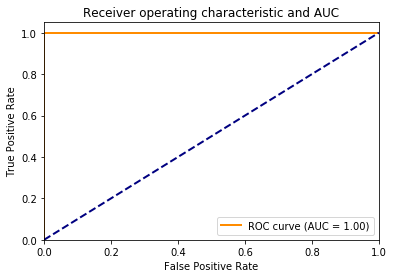

Confusion Matrix:
  [[60  0]
 [ 0  9]]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
                           Logit Regression Results                           
Dep. Variable:                label_b   No. Observations:                   69
Model:                          Logit   Df Residuals:                       59
Method:                           MLE   Df Model:                            9
Date:                Sun, 23 Jun 2019   Pseudo R-squ.:                   1.000
Time:                        23:28:57   Log-Likelihood:            -9.8486e-06
converged:                       True   LL-Null:                       -26.718
                                        LLR p-value:                 2.417e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

In [18]:
report(train_X, train_Y, y_predict, y_score, signif_list)

We can see the cofficients column and P>|t| columns which is the p-value column

 (d) v

In [19]:
y_predict_test = clf.predict(test_X[test_X.columns[signif_list]])
test_score = f1_score(test_Y, y_predict_test, average='weighted')
compare_df = pd.DataFrame()
compare_df = dict()
compare_df = {'Validation Score':score_df.iloc[0,0], 'Test Score':test_score}
compare_df = pd.DataFrame.from_dict(compare_df, orient='index')
compare_df

,0
Validation Score,1.0
Test Score,1.0


(d) vi
From the warning we can see we have a well-seprated problem. 

 (d) vii
From the confusion matrix, we can see there's 60 "not bending", but only 9 'bending'. So here I'm going to perfrom downsampling to make the number of 'not bending' 5 times as number of 'bending'.  

In [20]:
# select 15 instances from 60 to delete
print(train_dataset_1.shape)
randomSampleList = np.random.choice(60, 15, replace=False)
print(randomSampleList)
dsp_train_dataset_1 = train_dataset_1.drop(randomSampleList)
dsp_train_dataset_1.shape

(69, 44)
[29 19  6 47 15 24 30 32 36 57 17 14 42 16  7]


(54, 44)

In [21]:
train_X_dsp = dsp_train_dataset_1.iloc[:, 0:-2]
train_Y_dsp = dsp_train_dataset_1['label_b']
test_X_dsp = test_dataset_1.iloc[:, 0:-2]
test_Y_dsp = test_dataset_1['label_b']

In [22]:
y_predict_dsp, y_score_dsp, signif_list_dsp, clf = train(train_X_dsp, train_Y_dsp, 
                                                    test_X_dsp, test_Y_dsp)

Index(['mean1', '75%_1', '75%_2', 'max2', '50%_3', 'mean5', 'min5', '25%_5',
       'max5', 'max6'],
      dtype='object')


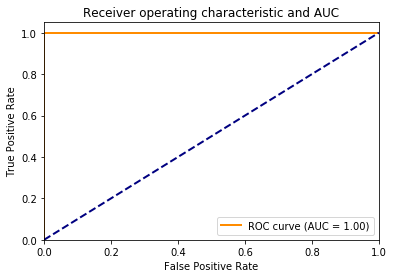

Confusion Matrix:
  [[45  0]
 [ 0  9]]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
                           Logit Regression Results                           
Dep. Variable:                label_b   No. Observations:                   54
Model:                          Logit   Df Residuals:                       44
Method:                           MLE   Df Model:                            9
Date:                Sun, 23 Jun 2019   Pseudo R-squ.:                   1.000
Time:                        23:28:57   Log-Likelihood:            -7.9386e-06
converged:                       True   LL-Null:                       -24.330
                                        LLR p-value:                 1.922e-07
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

In [23]:
report(train_X_dsp, train_Y_dsp, y_predict_dsp, y_score_dsp, signif_list_dsp)

 (e) i 

In [27]:
def select_best_l_l1_norm(l_list):
    score_report = list()
    for l in l_list:
        train_dataset_l, test_dataset_l = load_data(l)
        train_X = train_dataset_l.iloc[:, 0:-2]
        train_Y = train_dataset_l['label_b']
        train_X_norm = normalize(train_X)    
        test_X = test_dataset_l.iloc[:, 0:-2]
        test_Y = test_dataset_l['label_b']
        test_X_norm = normalize(test_X)
        

        model = LogisticRegressionCV(penalty='l1', solver='liblinear', Cs=10, refit=True)
        model = model.fit(train_X_norm, train_Y)
        score_cv = model.score(test_X_norm, test_Y)
        print(l, score_cv)
        score_report.append(score_cv)
    return score_report

In [28]:
score_report_l1 = select_best_l_l1_norm(l_list)

1 1.0
2 1.0
3 1.0
4 0.9868421052631579
5 0.9894736842105263
6 1.0
7 0.9774436090225563
8 0.9868421052631579
9 0.9883040935672515
10 0.9789473684210527
11 0.9808612440191388
12 0.9824561403508771
13 0.9757085020242915
14 0.981203007518797
15 0.9789473684210527
16 0.9802631578947368
17 0.9814241486068112
18 0.9766081871345029
19 0.9806094182825484
20 0.9815789473684211


 (e) ii
Apparently we got better average results than the p-value method as shown below. What's more, it's easier to implement.  

In [29]:
score_df_l1 = pd.DataFrame(score_report_l1)
score_df_l1.index = score_df_l1.index + 1
# score_df_l1 = pd.DataFrame(score_df.mean(axis=1))
score_df_l1.columns = ['score']
score_df_l1.index.names = ['l_value']
score_df_l1

,score
l_value,
1,1.000000
2,1.000000
3,1.000000
4,0.986842
5,0.989474
6,1.000000
7,0.977444
8,0.986842
9,0.988304


When l is 1 or 3 or 5, we get the best test score 1.000

In [30]:
def normalize(df):
    x = df.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled)
    return df

(f) i
L1 norm logistic regression

In [31]:
def load_data_multi_class(num_parts):
    train_dataset = list()
    test_dataset = list()
    for label in range(len(classes)):    
        class_path = folder_namedict + classes[label] + '/'
        path, dirs, files = next(os.walk(class_path))
        file_count = len(files)
#         trace(file_count)
        classData_train = list()
        classData_test = list()
        for fileIndex in range(1, file_count+1):
            csvname = class_path +file_name_prefix + str(fileIndex) + filetype
    #         print('processing ', csvname)
            df = pd.read_csv(csvname, skiprows=range(0, 4))
            num_singlepart = int(df.shape[0]/num_parts)
            for i in range(0, num_parts):
                df_p = df[:num_singlepart]
                df = df.drop(df.index[:num_singlepart])
                stat_pd = df_p.describe().drop('count').drop(columns='# Columns: time').transpose()
                newInstance = pd.concat([stat_pd.loc['avg_rss12'], 
                                         stat_pd.loc['var_rss12'], 
                                         stat_pd.loc['avg_rss13'], 
                                         stat_pd.loc['var_rss13'], 
                                         stat_pd.loc['avg_rss23'], 
                                         stat_pd.loc['var_rss23']], 
                                         axis=0, sort=False)

                newInstance = newInstance.to_frame().transpose()
                newInstance.columns = ['mean1', 'std1', 'min1', '25%_1', 
                                       '50%_1', '75%_1', 'max1', 'mean2', 'std2', 'min2', '25%_2', 
                                       '50%_2', '75%_2', 'max2', 'mean3', 'std3', 'min3', '25%_3', 
                                       '50%_3', '75%_3', 'max3', 'mean4', 'std4', 'min4', '25%_4', 
                                       '50%_4', '75%_4', 'max4', 'mean5', 'std5', 'min5', '25%_5', 
                                       '50%_5', '75%_5', 'max5', 'mean6', 'std6', 'min6', '25%_6', 
                                       '50%_6', '75%_6', 'max6'] 
            #     print(newInstance)
#                 classData.append(newInstance)
                if classes[label] == 'bending1' or classes[label] == 'bending2':
                    if fileIndex == 1 or fileIndex == 2:
                        classData_test.append(newInstance)
                    else:
                        classData_train.append(newInstance)
                else:
                    if fileIndex == 1 or fileIndex == 2 or fileIndex == 3:
                        classData_test.append(newInstance)
                    else:
                        classData_train.append(newInstance)
                        
        classData_test = pd.concat(classData_test, ignore_index=True)
        classData_train = pd.concat(classData_train, ignore_index=True)
        classData_train['label'] = classes[label]
        classData_test['label'] = classes[label]          
#         dataset.append(classData) 
        train_dataset.append(classData_train)
        test_dataset.append(classData_test)
    train_dataset = pd.concat(train_dataset, ignore_index=True, sort=False)
    test_dataset = pd.concat(test_dataset, ignore_index=True, sort=False)
    return train_dataset, test_dataset

In [32]:
def select_best_l_l1_norm_multi_class(l_list):
    score_report = list()
    for l in l_list:
        train_dataset_l, test_dataset_l = load_data_multi_class(l)
        train_X = train_dataset_l.iloc[:, 0:-1]
        train_Y = train_dataset_l['label']
        train_X_norm = normalize(train_X)    
        test_X = test_dataset_l.iloc[:, 0:-1]
        test_Y = test_dataset_l['label']
        test_X_norm = normalize(test_X)
        

        model = LogisticRegressionCV(penalty='l1', solver='liblinear', Cs=10, refit=True)
        model = model.fit(train_X_norm, train_Y)
        score_cv = model.score(test_X_norm, test_Y)
        print(l, score_cv)
        score_report.append(score_cv)
    return score_report

In [33]:
score_report_l1_multi_class = select_best_l_l1_norm_multi_class(l_list)

1 0.9473684210526315
2 0.7631578947368421
3 0.7894736842105263
4 0.7368421052631579
5 0.7052631578947368
6 0.8333333333333334
7 0.7819548872180451
8 0.8355263157894737
9 0.8070175438596491
10 0.7842105263157895
11 0.8373205741626795
12 0.8289473684210527
13 0.8137651821862348
14 0.7857142857142857
15 0.8245614035087719
16 0.7960526315789473
17 0.7987616099071208
18 0.827485380116959
19 0.814404432132964
20 0.7842105263157895


In [34]:
summary_multi_class = pd.DataFrame(score_report_l1_multi_class)
summary_multi_class.index = summary_multi_class.index+1
summary_multi_class = pd.DataFrame(summary_multi_class.mean(axis=1))
summary_multi_class.columns = ['Test score']
summary_multi_class.index.names = ['l_value']
summary_multi_class

,Test score
l_value,
1,0.947368
2,0.763158
3,0.789474
4,0.736842
5,0.705263
6,0.833333
7,0.781955
8,0.835526
9,0.807018


When l = 1, we get the best test score 0.947368.

In [35]:
train_dataset_1, test_dataset_1 = load_data_multi_class(1)
train_X = train_dataset_1.iloc[:, 0:-1]
train_Y = train_dataset_1['label']
test_X = test_dataset_1.iloc[:, 0:-1]
test_Y = test_dataset_1['label']

In [36]:
def train_multi_class(train_X, train_Y, test_X, test_Y):
    test_X_norm = normalize(test_X)
    train_X_norm = normalize(train_X)  

    model = LogisticRegressionCV(penalty='l1', solver='liblinear', Cs=10, refit=True)
    model = model.fit(train_X_norm, train_Y)
    y_predict = model.predict(test_X_norm)
    y_score = model.decision_function(test_X_norm)

    params = np.append(model.intercept_,model.coef_)

    return train_X_norm, train_Y, test_Y, y_predict, y_score, model

train_X_norm, train_Y, test_Y, y_predict, y_score, clf_multi_class = train_multi_class(train_X, train_Y, test_X, test_Y)

In [37]:
from itertools import cycle
from scipy import interp
from sklearn.preprocessing import label_binarize
def report_multi_class(train_X_norm, train_Y, test_Y, y_predict, y_score):
    lw = 2
    con_matrix = confusion_matrix(test_Y, y_predict)    
    train_Y = label_binarize(train_Y, classes=classes)
    test_Y = label_binarize(test_Y, classes=classes)
    y_predict = label_binarize(y_predict, classes=classes)
    n_classes = train_Y.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(test_Y[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(test_Y.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure()
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'pink', 'olive', 
                    'brown', 'wheat'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(classes[i], roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="upper left")
    plt.show()
    
    print("Confusion Matrix: \n", con_matrix)

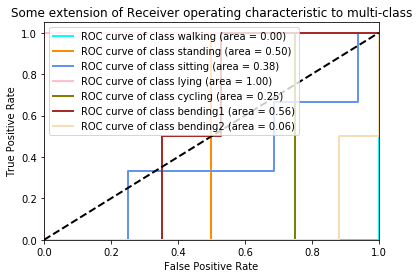

Confusion Matrix: 
 [[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 1 2 0]
 [0 0 0 0 0 0 3]]


In [38]:
report_multi_class(train_X_norm, train_Y, test_Y, y_predict, y_score)

The best l is 1

 (e) ii

 Gaussian Bayes

In [39]:
from sklearn.naive_bayes import GaussianNB
def Gaussian_Bayes(l_list):
    score_report = list()
    for l in l_list:        
        train_dataset_l, test_dataset_l = load_data_multi_class(l)
        train_X = train_dataset_l.iloc[:, 0:-1]
        train_Y = train_dataset_l['label']
        train_X_norm = normalize(train_X)    
        test_X = test_dataset_l.iloc[:, 0:-1]
        test_Y = test_dataset_l['label']
        test_X_norm = normalize(test_X)
                
        gnb = GaussianNB()
        model = gnb.fit(train_X, train_Y)
        score_cv = model.score(test_X, test_Y)
#         print(l, score_cv)
        score_report.append(score_cv)
    print("finished")
    score_report = pd.DataFrame(score_report)
    score_report.index = score_report.index+1
    score_report = pd.DataFrame(score_report.mean(axis=1))
    score_report.columns = ['Test score']
    score_report.index.names = ['l_value']
    return score_report

In [40]:
score_report_GNB = Gaussian_Bayes(l_list)
score_report_GNB

finished


,Test score
l_value,
1,0.894737
2,0.894737
3,0.894737
4,0.907895
5,0.873684
6,0.859649
7,0.849624
8,0.855263
9,0.853801


When l = 4, we get the best test score 0.907895 for gaussian Naive Bayes. 

Multi-nomial Bayes

In [44]:
from sklearn.naive_bayes import MultinomialNB
def Multi_normial_Bayes(l_list):
    score_report = list()
    for l in l_list:
        train_dataset_l, test_dataset_l = load_data_multi_class(l)
        train_X = train_dataset_l.iloc[:, 0:-1]
        train_Y = train_dataset_l['label']
        train_X_norm = normalize(train_X)    
        test_X = test_dataset_l.iloc[:, 0:-1]
        test_Y = test_dataset_l['label']
        test_X_norm = normalize(test_X)
        
        clf = MultinomialNB()
        selector = RFECV(clf, step=1, cv=5)
        selector = selector.fit(train_X, train_Y)
        score_cv = selector.score(test_X, test_Y)
#         print(l, score_cv)
        score_report.append(score_cv)
    print("finished")
    score_report = pd.DataFrame(score_report)
    score_report.index = score_report.index+1
    score_report = pd.DataFrame(score_report.mean(axis=1))
    score_report.columns = ['Test score']
    score_report.index.names = ['l_value']
    return score_report

In [45]:
score_report_MNNB = Multi_normial_Bayes(l_list)

finished


In [46]:
score_report_MNNB

,Test score
l_value,
1,0.894737
2,0.763158
3,0.754386
4,0.750000
5,0.757895
6,0.745614
7,0.759398
8,0.769737
9,0.771930


When l is 1, we get the best test score 0.894737

 (f) iii

L1-norm logistic regression has thebest test score 0.947368 which makes it  best performer